#### Project Organization:

  * repo on DLR Gitlab with code
  * this notebook and the contained explanation
  * paper repository: https://ci.inf-i2.uni-jena.de/ ... 
  * _no_ information on DLR Wiki or Uni Wiki
  

## Idea

The idea is to generate better contour levels for the plotting of a 2d density function as contour plot. Let this probability density function be $p(x,y)$ with $x,y \in R$. And let $L$ be the increasingly ordered sequence of levels to be used as contour levels. Since $p$ is a pdf it holds:
 - $\forall x,y \in R: p(x,y) > 0$
 - $\int_{R x R} p(x,y) dx dy = 1$
 
Moreover, a cummulative distriubtion function (cdf) for $p$ exists as follows:

$F(x,y) = P(X\leq x, Y\leq y)$

### Problem Statement ###

A contour plot shows a function $f(x,y) \mapsto z$, where all variables $x$, $y$ and $z$ are real-valued. Typcially $x$ and $y$ are encoded along the horizontal and vertical position, whereas the value of the function $z$ is visualized with contour lines (also called isoclines, isopleth, or equipotential curve). A contour line is a curve where $f$ has equal value $v$ and we call $v$ a contour level. We denote $L = \{l_1, \dots, l_k\}$ with $l_i \leq l_{i+1}$ the ordered set of $n$ contour levels.

While there is other aspects in the design space of contour plots (e.g include the coloring of the contour lines and/or the space between two neighbouring contour lines using a colormap encoding the value of $z$.), here we focus on the problem of finding suitable contour levels. In particular we suggest an alternative method of determining contour levels for a particular domain: probability density functions.

Note that in any actual contour plot only a relatively small number of contour levels is used. Obviously, if one draws too many contour lines visual clutter occurs. However, the less contour lines are drawn the less fine-grained information is represented in the plot. Hence, the target is to maximize the information content for the viewer even for a fixed number of contour lines.

We aim to find a suitable function(algorithm) $c$ that determines $n$ contour levels $L$ for a given pdf $p$ that will be plotted in the range $x \in [x_{min}, x_{max}]$ and $y \in [y_{min}, y_{max}]$:

$$ c_p(k, [x_{min}, x_{max}], [y_{min}, y_{max}]) \mapsto (l_1, \dots, l_k) \text{ where } l_i \in \{0, \inf\} $$


### State of the art ###
A literature review revealed no dedicated publications about this problem (except for this unpublished website).

It seems that only the naive procedure is used, which essentially chooses $k$ levels evenly along the range of values of $p(x,y)$:

  1. determine the maximum of $p(x,y)$ in the range to plot as $p_{max}$.
  2. select $k+2$ equi-distant points in the range $[p_{min},p_{max}]$ and throw the first point (at $0$) and last point (at $p_{max}$)
  3. use the resulting sequence of $k$ points as contour levels $L$

It may serve as another hint that this problem is underexplored that many common visualization libraries and tools do not allow the manual specification of desired contour levels or another way of altering the contour levels (other than providing a soft or hard constraint for the number of levels).

### New Idea: levels of equal density ###

In one sentence, the traditional approach does a "vertical" equi-cut with respect to the *extent* of density values. The new idea is to do it with respect to the *cumulative density*, i.e. we cut into levels such that the probability that a random sample falls into each of the levels is equal.

$$ \forall i\in k: \int_{x,y \in R^2: l_{i-1} < p(x,y) <= l_i} p(x,y) = 1/k $$

(the normalization with 1 assumes incorrectly that we cover the whole $R x R$)

With this procedure all regions enclosed by two adjacent contour curves have equal _probability_. With the old procedure the _density_ increased equally between two contour levels.

## Intuition

The essential claim of this work is that in many scenarios the viewer of a plot is not interested in the actual probability density value. Instead the viewer want to understand how probable certain events are. This is, he cares for the probability of events, not the density value of a point. 

To illustrate our point let us move to another domain: catography. 
When drawing maps of terrains contour lines are used to illustrate the height of terrain. And it indeed makes sense that these contour lines are drawn at equally spaced heights: It provides the viewer an anker to understand the slope of the terrain. The overall impression provides an impression on the shape of the terrain. What these height lines do not convey - and do not intend to - is the volume of earth beneath it. 
Going back to the domain of probability density functions we argue, however, that this volume (the probability) is exactly what a viewer expects to see, while what is typcially presented is the height (the density).

See also figure TODO (Add illustrative comparision of density based and probability based vis)

For simple distributions the difference of the two ways of presentation not large, and while we expect no significant improvement in these cases there is also no harm in using our new visualization technique. For complex distributions, however, we see a signification improvement over the state of the art. See Section XX.


## Benefits

So far we have been able to identify the following practical scenarios where our new technique proved beneficial. Note that we do not provide suitable visualizations here. You can find them in the next section, 'case studies'.

 - a single or multiple spikes dominate the density function. In the traditional way almost only the spike will be visible, but nothing else. From a technical point of view the problem is, that many of the contours actually carry very little probability. 

 - underestimation of the weight of long-tailed distributions. With our technique the actual structure and shape of these area of low density (but overall not so low probability) are revealed better.
 
 - cut-off distributions: in 'plateau-ed' density functions the gap to zero density 
 
 - comparision of distributions: when drawing two distribution side by side in order to compare them, one needs to make sure that the visual primitives and encodes indeed are comparable. With the standard way I think they are not or problematic. Not comparable: If you choose individual level heights they obviously are not comparable. Only the visual shape, the 'gestalt' is comparable. Problematic: If you choose equal levels heights, you easily run into problems of scale and do not see anything. In turn, with the new technique it would be comparable, since level corresponds to a particular probability - and that holds across visualizations.

## Disadvantages

 - cut-off distributions: our technique cannot show the exact boarder where the density drops to zero. Instead it will show a contour more to the inside of the plateau

## Related Work
  
 * https://en.wikipedia.org/wiki/Contour_line
 * https://people.sc.fsu.edu/~jburkardt/m_src/levels/levels.html
 * http://www.lumina.com/blog/percentile-contour-plots
 * https://ebookcentral.proquest.com/lib/dlr-ebooks/detail.action?docID=1895499 (nur vom DLR aus verfügbar)
 * [vis of high dim data : advances in past decade](http://www.sci.utah.edu/~shusenl/highDimSurvey/website/)

 * related work [paper by scott](https://pdfs.semanticscholar.org/2f5a/2ca3c410c209cdc19c71582085f44c89e902.pdf)
  * "In summary, nonparametric approaches are always appropriate for exploratory purposes"
  * Statistical modeling of data has two general purposes:
    - (1) understanding the shape and features of data through the density function, and
    - (2) prediction of x through the joint density function f(x,y)
  * nonparametric density estimators:
  * higher variance, lower bias
  * parametric density estimators:
    * lower variance, higher bias
    * "\[...\] using parametric methods to explore data makes little sense."
  * "The shape of the density cannot easily be determined algebraically, but visualization methodology can assist in this task" 

 * [Jussi Klemel](http://jklm.fi/)
 
 * related work, that is in a different aspect:
  * [exploring bandwith-value in kde](https://www.tandfonline.com/doi/abs/10.1080/10618600.1993.10474599)
  * related example in scalar field visualization is that of selection of a transfer function, or colormap
    * [paper by He]()
 
 
 * search terms:
  * probability density function
  * quantiles plots
  * contour plot
  * level sets
  * cummulative density function
  * high dimensional function visualisation
 
 * ToDo search terms:
  * isovalue selection
  * iso value selection
  * scalar field visualization
  
 * ToDo [read this paper](https://ieeexplore.ieee.org/stamp/stamp.jsp?tp=&arnumber=663875)
  * in particular the related works section



__=> nobody talks about how to choose the contour levels__

 * we propse an alternative way to chose the levels for density function
 * we yet have to define, what this will be better for (i.e. which is the tasks)
 * the "why?" is then straightforward: improved task efficiency!

## validation

It is essential to validate that it brings any benifit over the state of the art. Here we collect ideas on how to validate.

**Validation by Demonstration**
 * use a series of well-selected and representative examples, both artifical and real
 * show that it generally does not worsen the visualization
 * show that it at times improves the visualization

**Empirical quantitative user study**
 * -> need to do literature review to find suitable tasks
 
 * tasks to solve by the participants:
  * how probable is that a random data point lies within this given area?
  
 * run a study where users manually select k contour lines such that the resulting contour map best represents the density function. For that purpose provide a rotatable 3d view on the density funcion
  

## Code and Examples

In [1]:
import pandas as pd
import numpy as np

import plotly
import plotly.plotly as py
import plotly.graph_objs as go

# to allow offline creation of plotly plots
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
init_notebook_mode(connected=True)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# own modules for generation and plotting
%load_ext autoreload
#%autoreload 1  # enable auto-reloading for those imports imported with %aimport
# %aimport iso_levels
# %aimport stats
# %aimport examples
# %aimport plotting
# %aimport utils

%autoreload  # autoreload everything!
import iso_levels
import stats
import examples
import plotting
import utils

ToDo

 * plot level values
 * plot "cdf" over p-value ordered support points
 * plot the above two together

## case studies

### one-dimensional case

In [3]:
indexes = utils.normalize_to_indexes(low=[-3], high=[3], n=100, d=1)
gp1d = examples.support_gaussian_1d(indexes)[0]
levels = iso_levels.equi_prob_per_level(gp1d, k=5)
levels2 = iso_levels.equi_value(gp1d, k=5)

In [4]:
print(levels)

[0.15744319 0.2566174  0.31291556 0.35978656 0.3900672 ]


In [5]:
def get_cross_point(x, y, levels):
    """Given the support of a scalar function f(x)=y return the cross points with levels in x-increasing order as the
    sequence of x coordinates."""
    pass
        

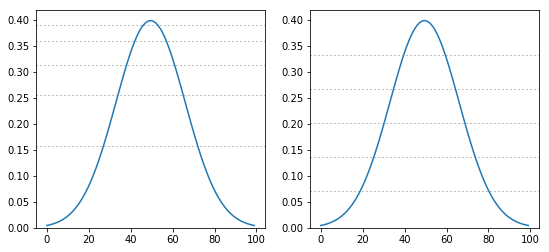

In [6]:
figure = plt.figure(figsize=(9,4))
ax = figure.add_subplot(121)
plotting.density(levels, gp1d, ax=ax)
ax = figure.add_subplot(122)
plotting.density(levels2, gp1d, ax=ax)

## case 2d densities

do the same on 2d plot and draw contour plots with our new technique

 1. choose/define 2d density function
 2. get 2d support
 3. normalize to probability for each voxel 
 4. sort by probabiliy
 5. calculate cumulative prob
 6. find density values that make cum_prob exceed certain thresholds

In [7]:
indexes = utils.normalize_to_indexes(low=[-2, -2], high=[2, 2], n=50)
p = examples.support_gaussian_2d(indexes=indexes)
k = 5
levels_pdf = iso_levels.equi_value(p, k)
levels_prob = iso_levels.equi_prob_per_level(p, k)

In [8]:
plotting.contour_comparision_plot_2d([levels_pdf, levels_prob], p, indexes=indexes, labels=['old', 'new'])

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 576x288 with 2 Axes>

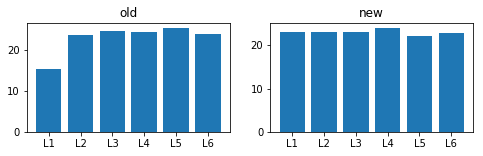

In [9]:
plotting.plot_contour_levels_stat([levels_pdf, levels_prob], [p, p], ['old', 'new'])

Now let's try with a more interesting probability density function. We will take it from Lumen. Or actually even simpler, we can just export the data directly from Lumen.

### Example empirical allbus data set
This is a screenshot from lumen

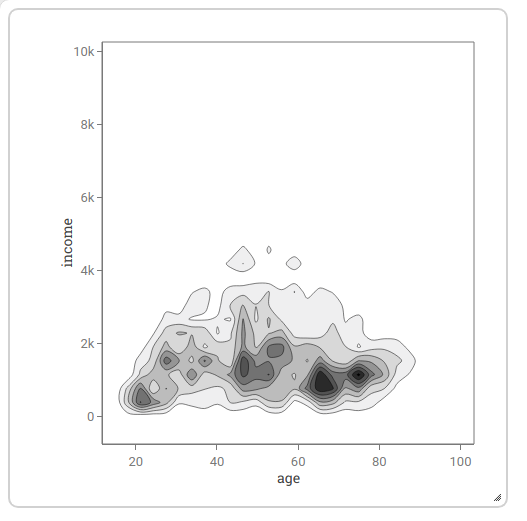

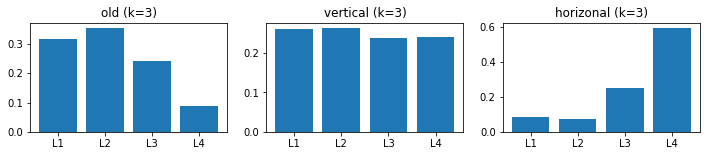

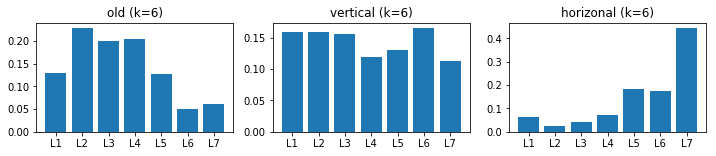

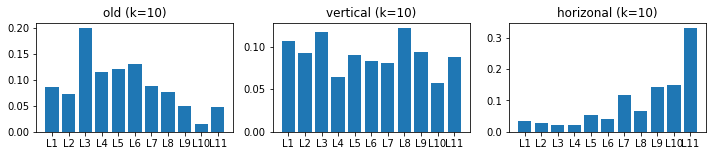

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 864x288 with 3 Axes>

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 864x288 with 3 Axes>

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 864x288 with 3 Axes>

In [10]:
df = pd.read_csv('allbus_age-vs-income.csv', index_col=False)
allbus_p = df['p'].values
plotting.plot_combined(allbus_p, k=[3, 6, 10])

I wonder why the weights are not equally distributed along the levels, so let's look at it:

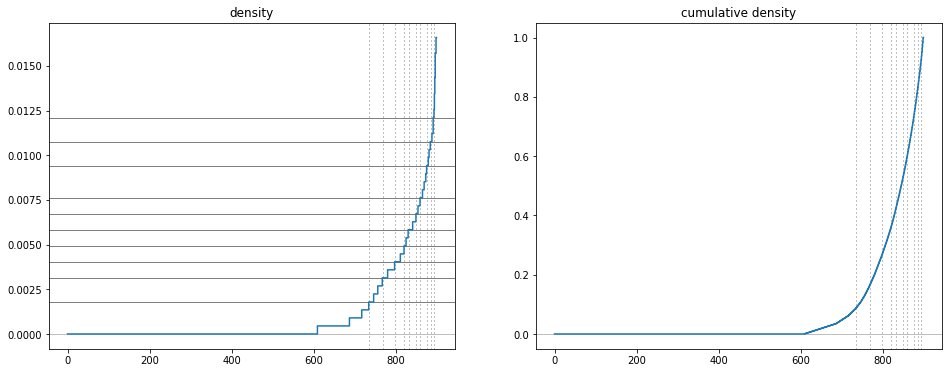

In [11]:
levels_pdf = iso_levels.equi_prob_per_level(allbus_p, 10)
fig, ax = plt.subplots(figsize=[16,6], nrows=1, ncols=2)
plotting.plot_sorted_density(levels_pdf, allbus_p, ax=ax[0])
plotting.plot_cumulative_density(levels_pdf, allbus_p, ax=ax[1])

### artificial 'bad' plots

#### 1. sum of sharp gaussian and wide gaussian


In [12]:
gindex =  utils.normalize_to_indexes(low=[-2, -2], high=[2, 2], n=100)
p1 = examples.support_gaussian_2d(indexes=gindex, sigma=[[1.0, 0], [0, 1]])
p2 = examples.support_gaussian_2d(indexes=gindex, sigma=[[0.005, 0], [0, 0.005]])

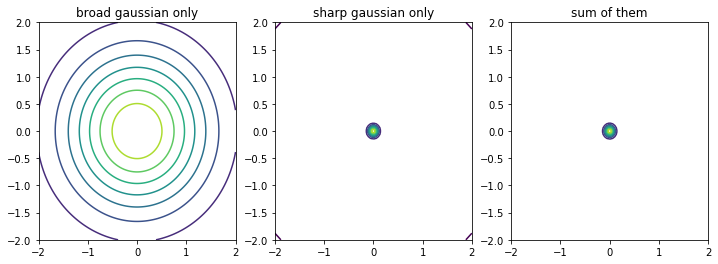

In [13]:
fig = plt.figure(figsize=(12,4))
ax = fig.add_subplot(131, title="broad gaussian only")
plotting.contour(p1, gindex[0], gindex[1], ax=ax)

ax = fig.add_subplot(132, title="sharp gaussian only")
plotting.contour(p2, gindex[0], gindex[1], ax=ax)

ax = fig.add_subplot(133, title="sum of them")
plotting.contour(p1+p2, gindex[0], gindex[1], ax=ax)

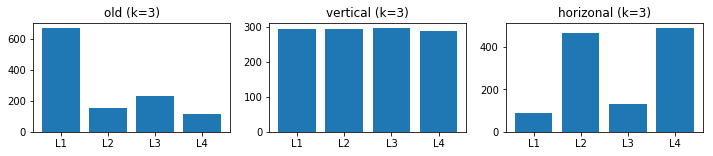

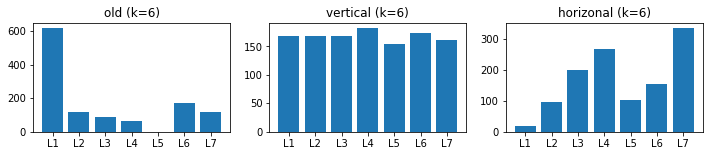

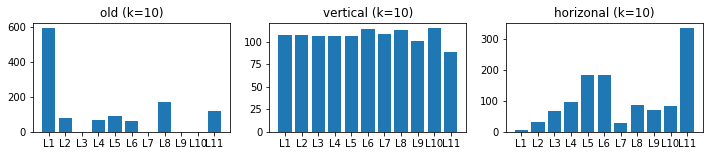

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 864x288 with 3 Axes>

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 864x288 with 3 Axes>

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 864x288 with 3 Axes>

In [14]:
plotting.plot_combined(p1+p2, indexes=gindex, k=[3, 6, 10])

### sharp gaussian is offset

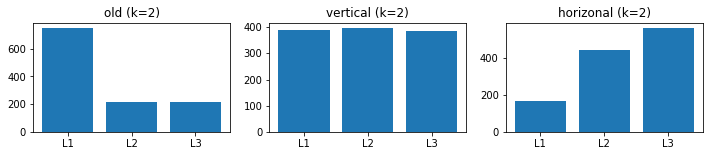

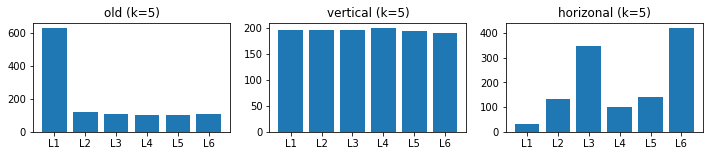

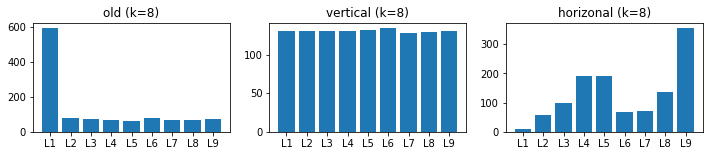

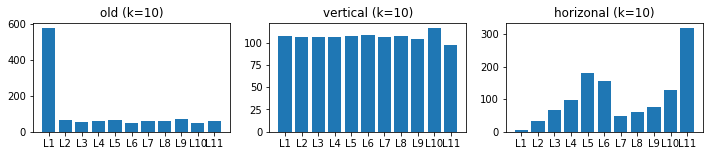

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 864x288 with 3 Axes>

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 864x288 with 3 Axes>

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 864x288 with 3 Axes>

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 864x288 with 3 Axes>

In [15]:
p3 = examples.support_gaussian_2d(indexes=gindex, mu=[0.25,0.25], sigma=[[0.02, 0], [0, 0.02]])
plotting.plot_combined(p1+p3, indexes=gindex, k=[2, 5, 8, 10])

#### three gaussians 

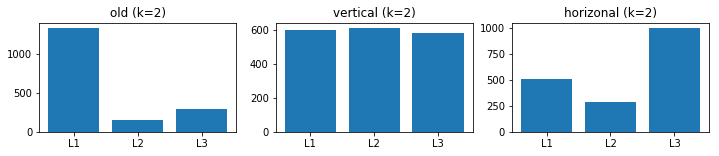

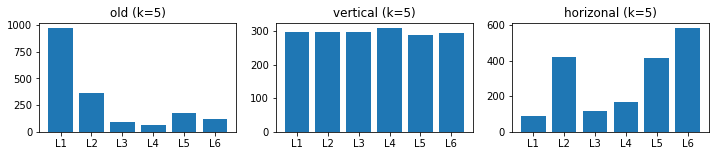

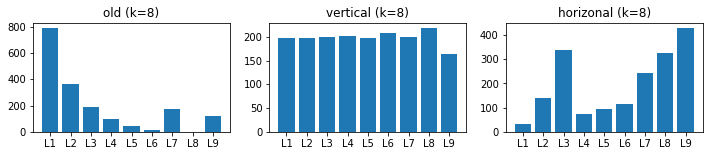

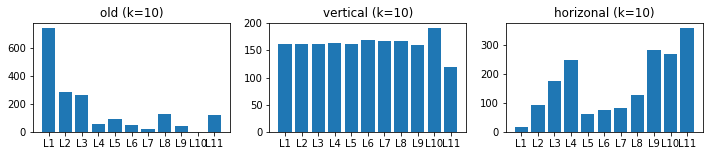

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 864x288 with 3 Axes>

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 864x288 with 3 Axes>

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 864x288 with 3 Axes>

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 864x288 with 3 Axes>

In [16]:
plotting.plot_combined(p1+p2+p3, indexes=gindex, k=[2, 5, 8, 10])

#### again something else

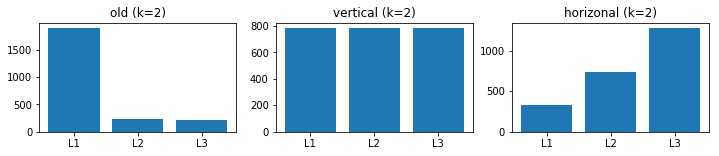

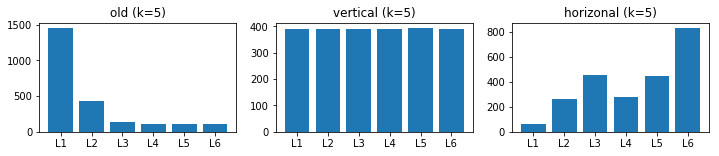

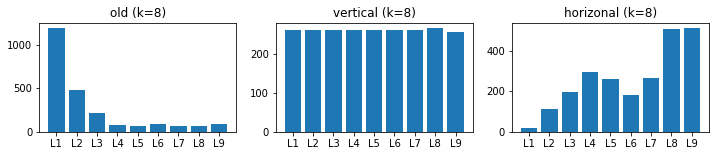

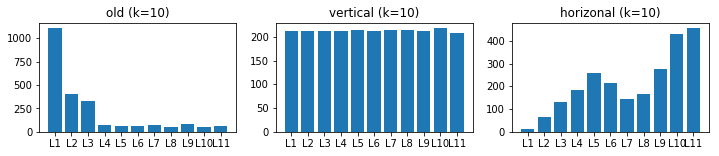

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 864x288 with 3 Axes>

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 864x288 with 3 Axes>

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 864x288 with 3 Axes>

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 864x288 with 3 Axes>

In [17]:
p4 = examples.support_gaussian_2d(indexes=gindex, mu=[-0.35,-0.35], sigma=[[0.07, 0], [0, 0.1]])
plotting.plot_combined(2*p1 + p3 + p4, indexes=gindex, k=[2, 5, 8, 10])

In [18]:
from functools import reduce
import operator
import matplotlib as mpl

In [19]:
mpl.rc('lines', linewidth=0.5, color='black')

In [20]:
mu = [0, 1, 3.5, 7]
sigma = [0.05, 0.5, 0.7, 2]
weights = [0.6, 1, 0.7, 1]

In [21]:
indexes = utils.normalize_to_indexes(low=[-1], high=[10], n=100, d=1)[0]
ps1d = [examples.support_gaussian_1d(indexes, m, s) for m, s in zip(mu, sigma)]
gp1d = sum(map(operator.mul, weights, ps1d))
levels = iso_levels.equi_prob_per_level(gp1d, k=5)
levels2 = iso_levels.equi_value(gp1d, k=5)

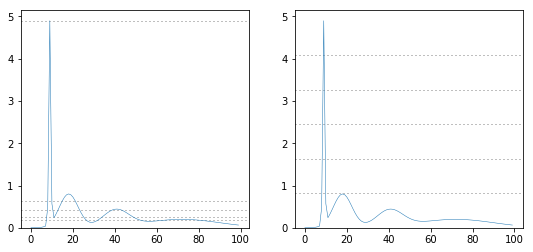

In [22]:
figure = plt.figure(figsize=(9,4))
ax = figure.add_subplot(121)
plotting.density(levels, gp1d, ax=ax)
ax = figure.add_subplot(122)
plotting.density(levels2, gp1d, ax=ax)

In [23]:
gindex = utils.normalize_to_indexes(low=[-1, -3], high=[10, 3], n=50)
ps2d = [examples.support_gaussian_2d(indexes=gindex, mu=[m, 0], sigma=[[s, 0], [0, s]]) for m, s in zip(mu, sigma)]
gp2d = sum(map(operator.mul, weights, ps2d))
# levels = iso_levels.equi_prob_per_level(gp2d, k=5)
# levels2 = iso_levels.equi_value(gp2d, k=5)

In [24]:
gp2d.shape

(50, 50)

In [33]:
mpl.rcParams

RcParams({'_internal.classic_mode': False,
          'agg.path.chunksize': 0,
          'animation.avconv_args': [],
          'animation.avconv_path': 'avconv',
          'animation.bitrate': -1,
          'animation.codec': 'h264',
          'animation.convert_args': [],
          'animation.convert_path': 'convert',
          'animation.embed_limit': 20.0,
          'animation.ffmpeg_args': [],
          'animation.ffmpeg_path': 'ffmpeg',
          'animation.frame_format': 'png',
          'animation.html': 'none',
          'animation.html_args': [],
          'animation.writer': 'ffmpeg',
          'axes.autolimit_mode': 'data',
          'axes.axisbelow': 'line',
          'axes.edgecolor': 'black',
          'axes.facecolor': 'white',
          'axes.formatter.limits': [-7, 7],
          'axes.formatter.min_exponent': 0,
          'axes.formatter.offset_threshold': 4,
          'axes.formatter.use_locale': False,
          'axes.formatter.use_mathtext': False,
          'axes.f

In [27]:
from plotting import plot_combined

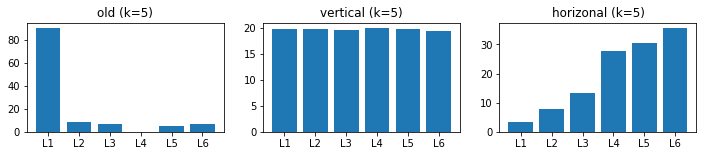

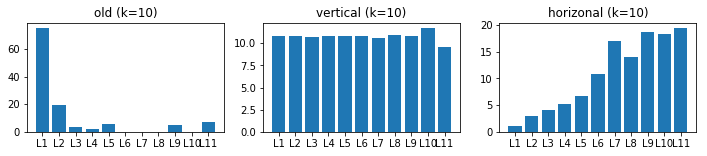

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 864x288 with 3 Axes>

TypeError: Cannot cast array data from dtype('<U1') to dtype('float64') according to the rule 'safe'

<Figure size 864x288 with 3 Axes>

In [28]:
plot_combined(gp2d, indexes=gindex, k=[5, 10])

### dirichlet distribution

yeah... that is not so easy because the distribution lives on a simplex ... 

In [22]:
from scipy.stats import dirichlet

def dirichlet_support(alpha=[0.5, 0.5], n=5):
    """generate data for a multivriate dirichlet
    
    DOES NOT WORK
    """
    pos = _grid_points(n)
    print(pos)
    rv = dirichlet(alpha)
    return {
        'x': pos[:, :, 0],
        'y': pos[:, :, 1],
        'pdf': rv.pdf(pos)
    }    

In [23]:
dirichlet.pdf([0.2], [0.1,0.2])
#gm1 = dirichlet_support(alpha=[0.1, 0.2], n=3)
#gm2 = dirichlet_support(alpha=[0,0])
#gm3 = dirichlet_support(alpha=[0.5,0.5])
#plot_combined(gm2['x'], gm2['y'], 2*gm1['pdf'] + gm2['pdf'] + gm3['pdf'], k=3)

0.3485514185821718

### iris kde (auto bandwitdth)

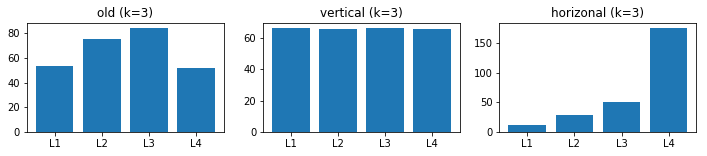

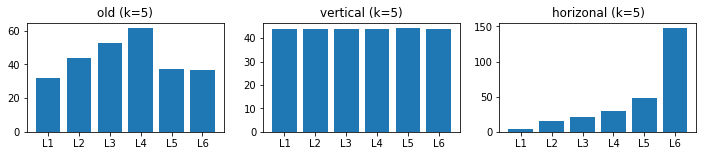

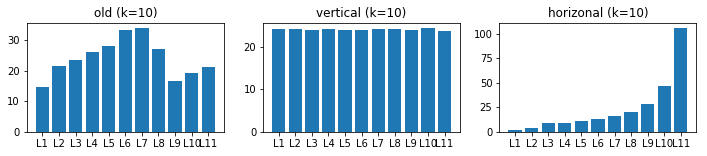

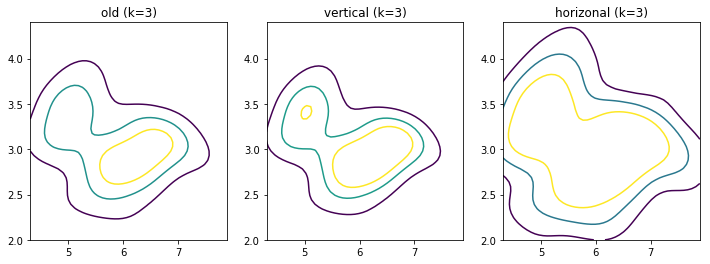

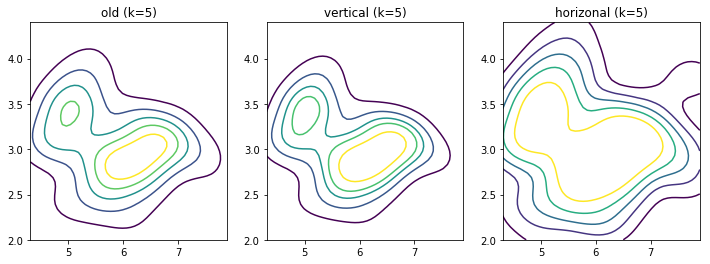

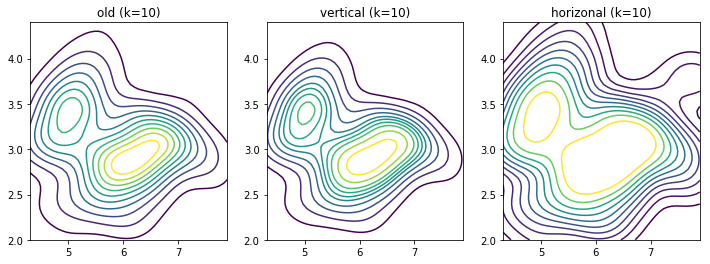

In [24]:
# get data
from sklearn import datasets
iris = datasets.load_iris()
data = iris.data[:, :2].transpose()

# derive pdf
mykernel = examples.pdf_kernel(data, kernel_bandwidth=None)

# get support
indexes = utils.normalize_to_indexes(data=data)
p = examples.support_kde(mykernel, indexes)

# plot
plotting.plot_combined(p, indexes[0], indexes[1], k=[3, 5, 10])

### iris kde (alpha = 0.1)

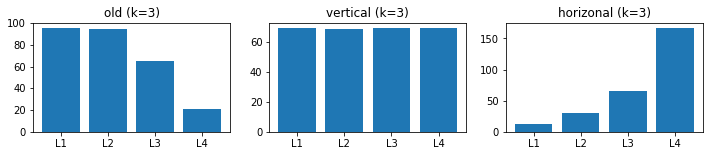

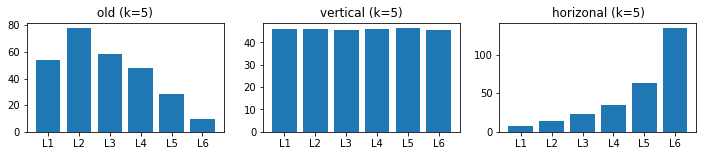

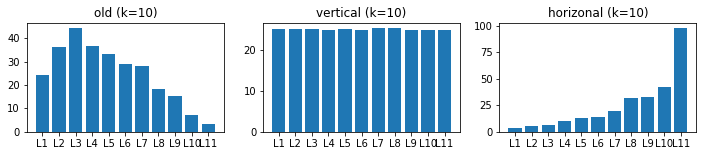

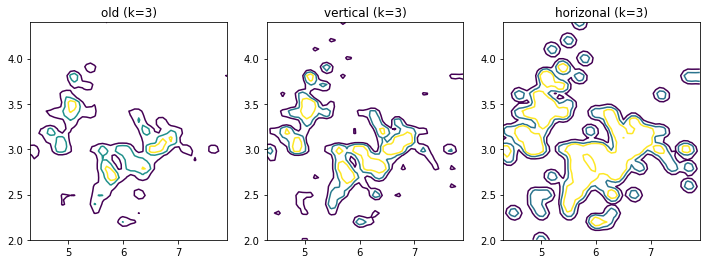

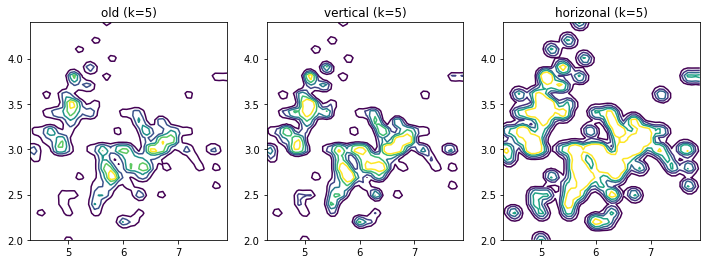

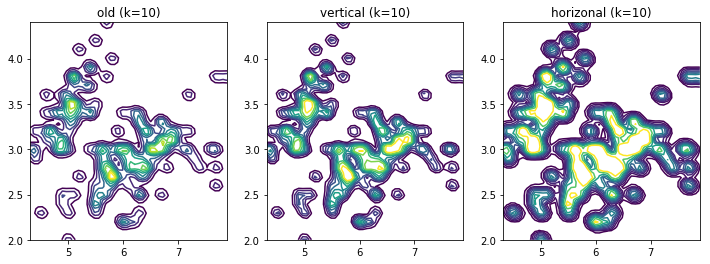

In [25]:
mykernel = examples.pdf_kernel(data, kernel_bandwidth=0.1)
p = examples.support_kde(mykernel, indexes)
plotting.plot_combined(p, indexes[0], indexes[1], k=[3, 5, 10])

### another real example from lumen

this is the 'emp_titanic' data set with 2d_resolution set to 100.
As you can see you cannot see anything but the peak, even though it is obvious in the marginals that there is more structure.


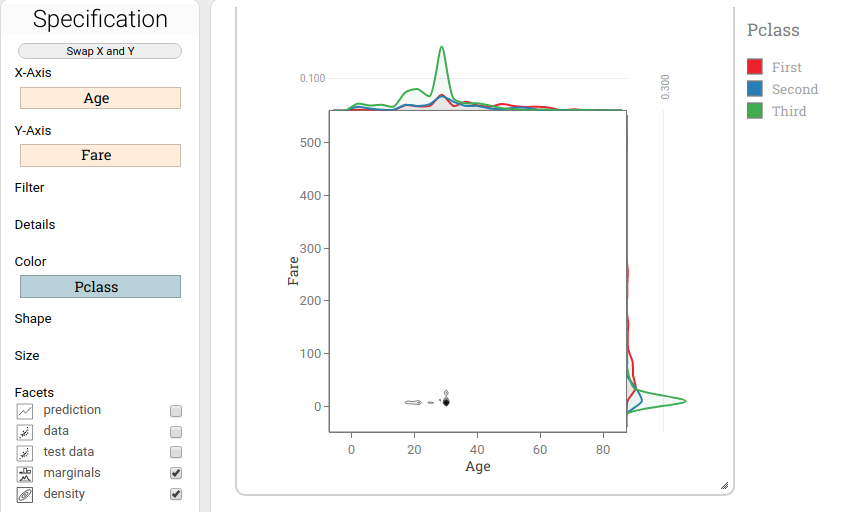

now lets draw it again with our technique

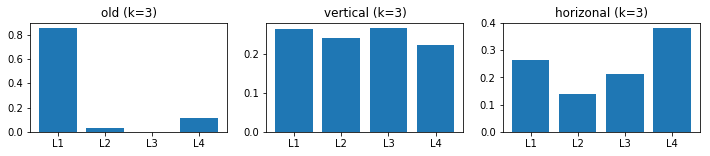

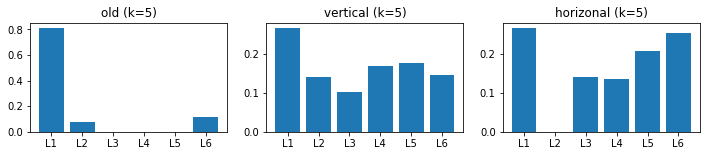

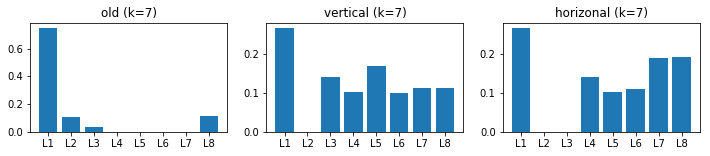

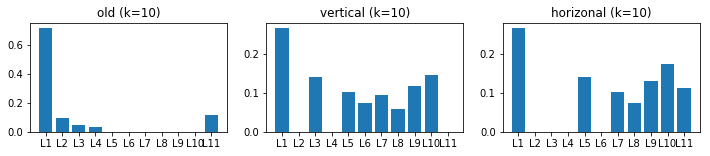

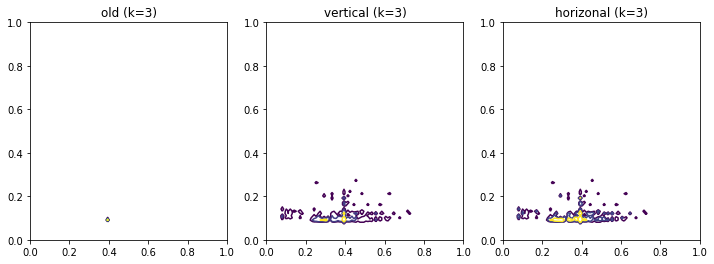

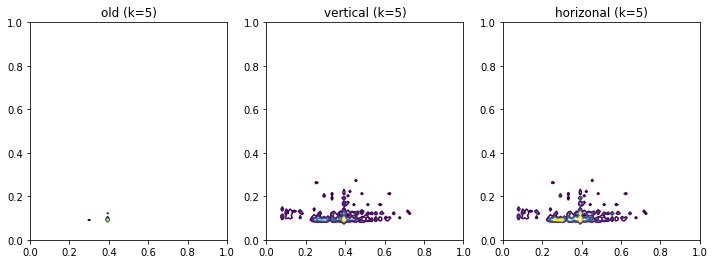

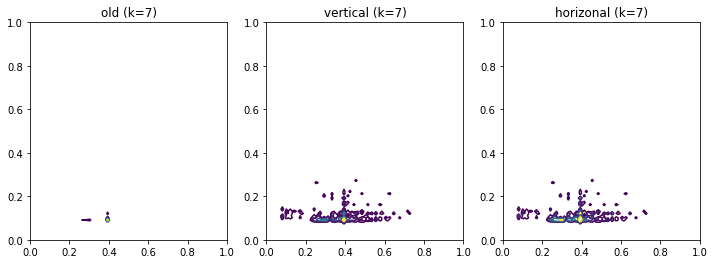

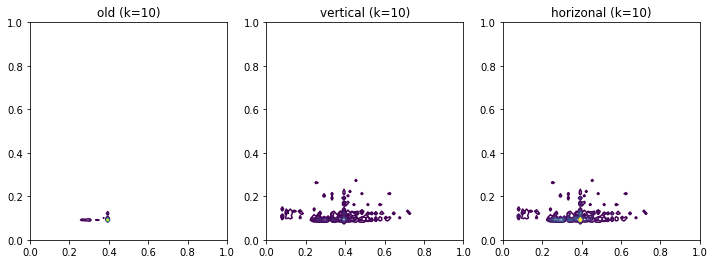

In [26]:
df = pd.read_csv('titanic_age-vs-fare.csv', index_col=False)
titanic_p = df['p'].values
plotting.plot_combined(titanic_p, k=[3, 5, 7, 10])

## titanic - KDE

the previous example shows the empiricial model for titanic. Now we derive a KDE model for the same projection and plot it.

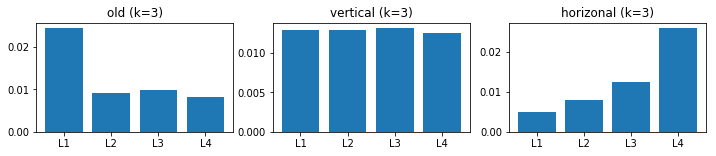

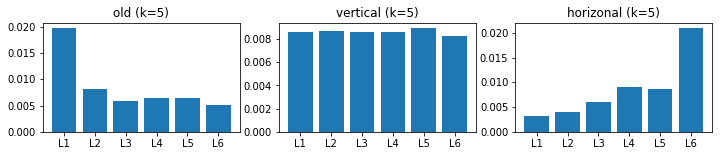

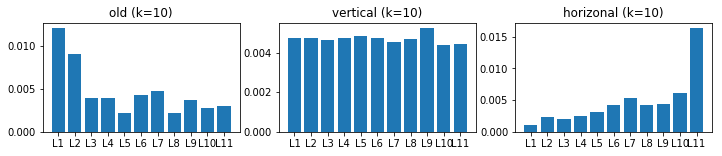

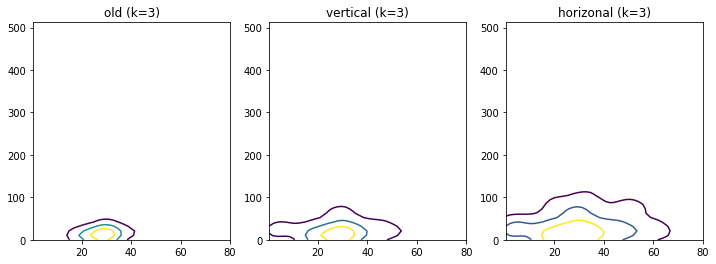

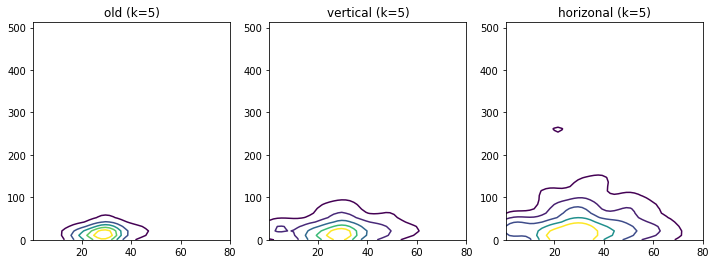

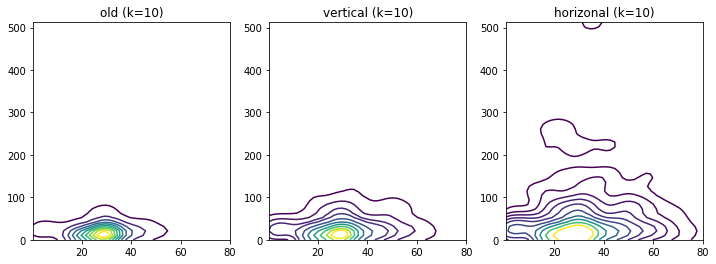

In [38]:
# get data
titanic = pd.read_csv('./data/titanic_mixed.csv', index_col=None, usecols=['Age', 'Fare'])
data = titanic.values.transpose()

mykernel = examples.pdf_kernel(data, kernel_bandwidth=None)

# get support
indexes = utils.normalize_to_indexes(data=data)
p = examples.support_kde(mykernel, indexes)

# plot
plotting.plot_combined(p, indexes[0], indexes[1], k=[3, 5, 10])

### Titanic KDE - bandwidth set

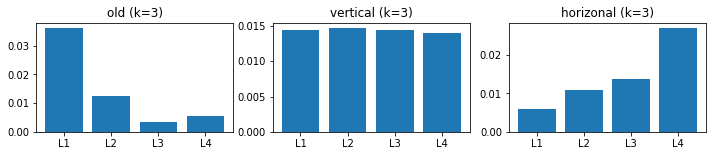

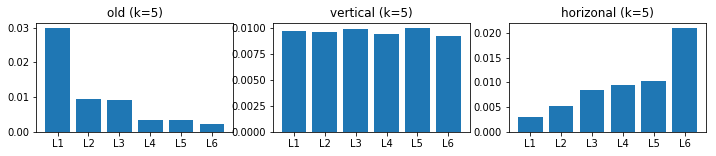

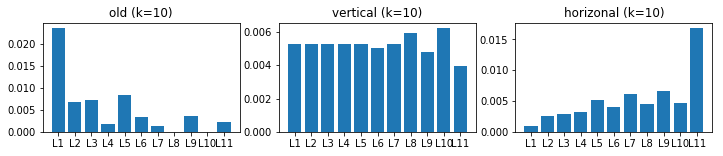

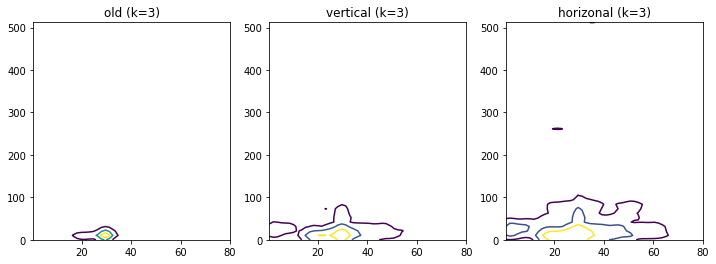

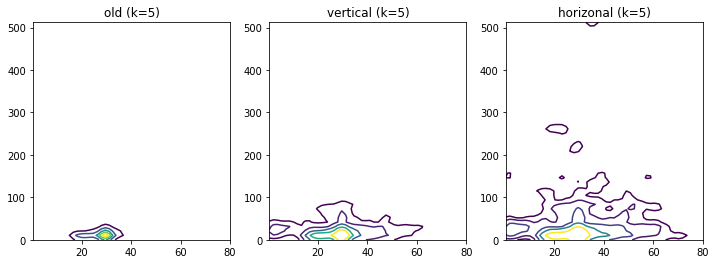

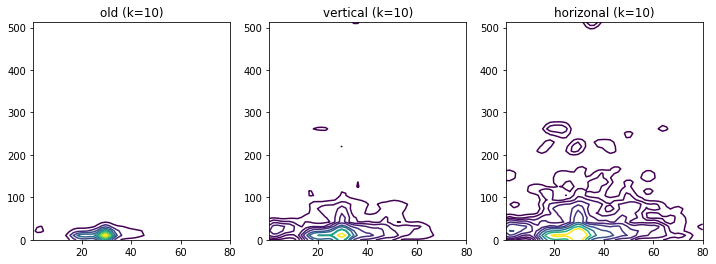

In [42]:
mykernel = examples.pdf_kernel(data, kernel_bandwidth=0.15)
p = examples.support_kde(mykernel, indexes)
plotting.plot_combined(p, indexes[0], indexes[1], k=[3, 5, 10])

## another example from lumen

Take this screenshot from Lumen, and see how it improves with the new techniques.

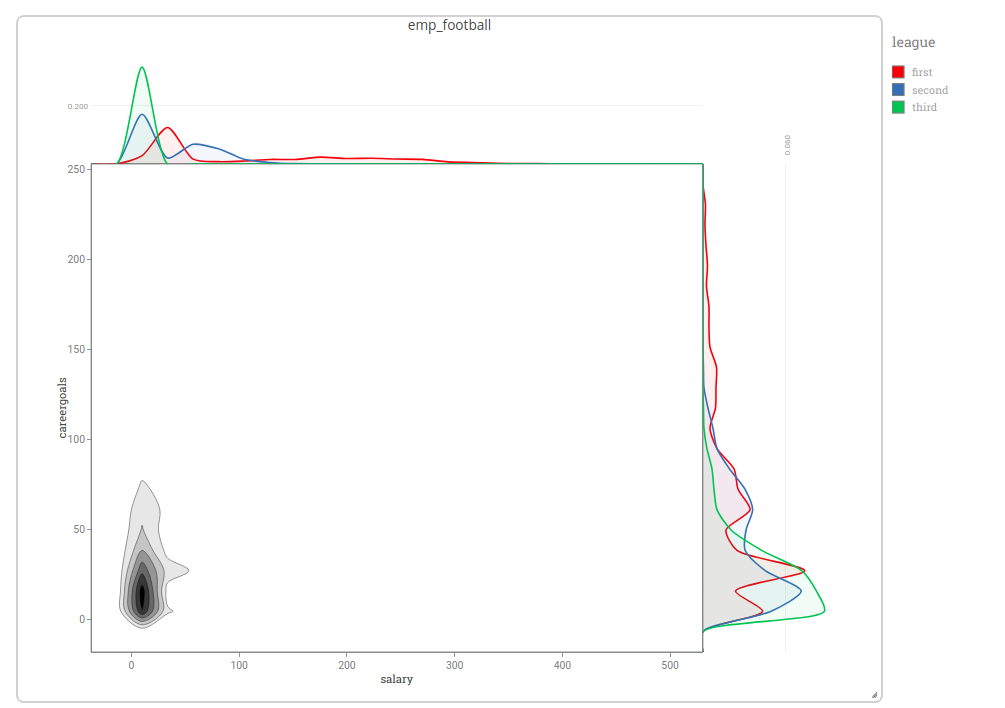

#### redraw the density values directly


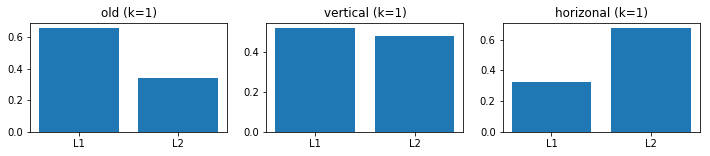

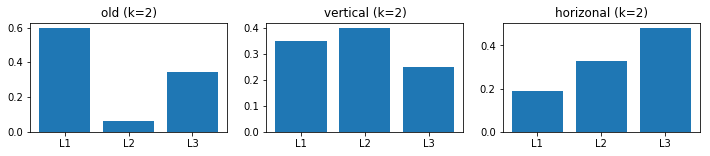

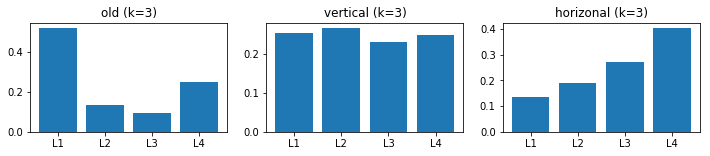

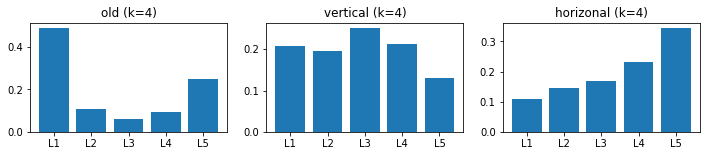

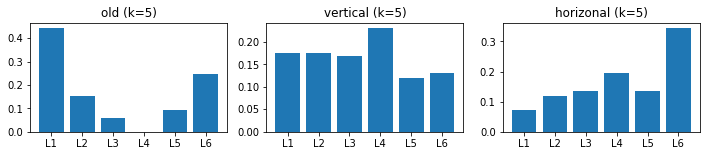

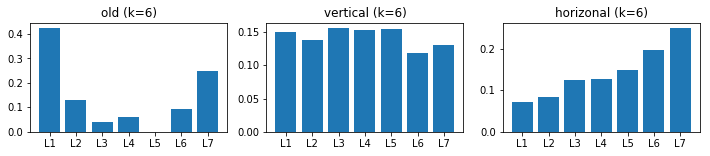

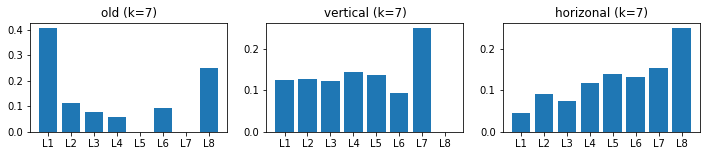

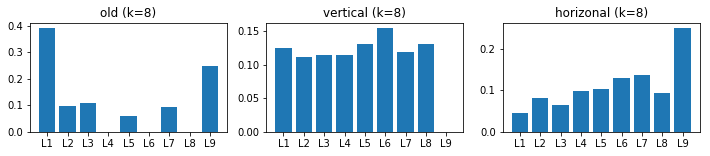

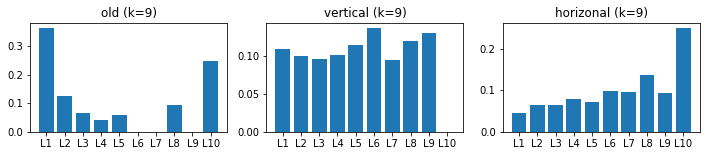

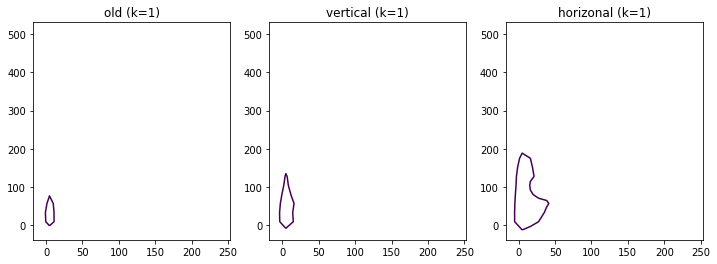

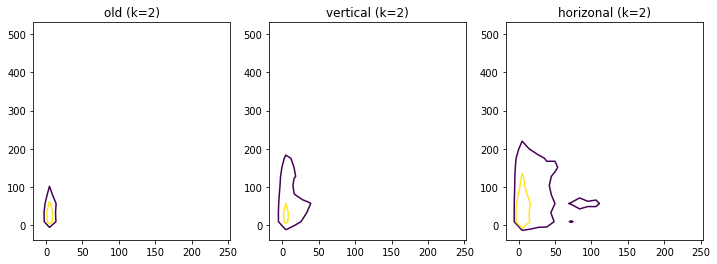

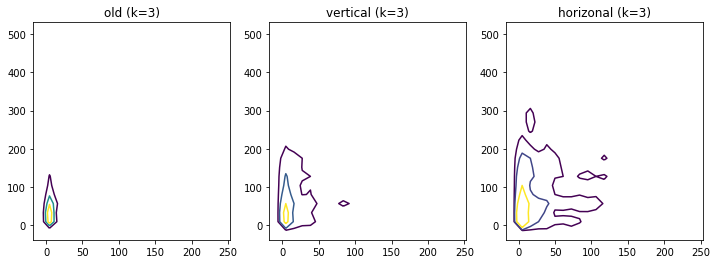

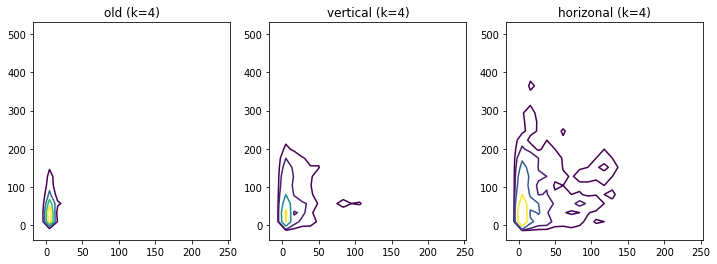

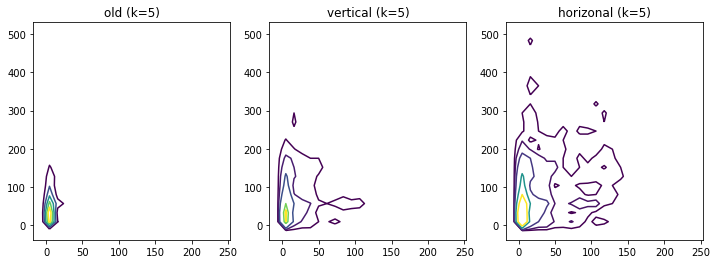

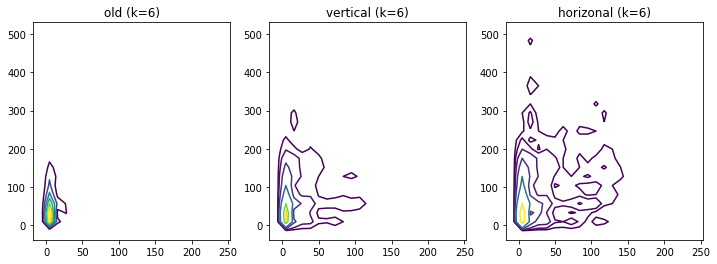

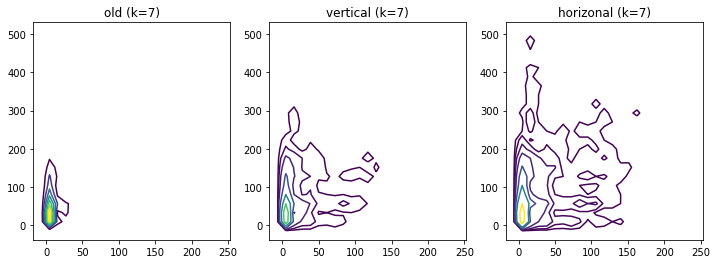

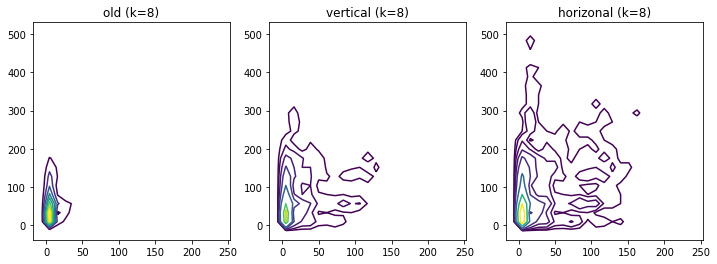

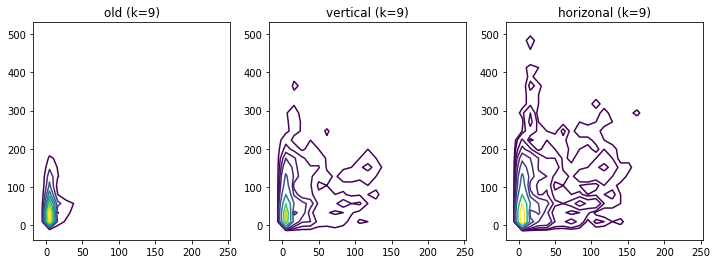

In [108]:
df = pd.read_csv('data/emp_football-density-salary_vs_careergoals.csv', index_col=False).iloc[:,:3]
data = df.values.transpose()  # get data by attribute
x, y = utils.normalize_to_indexes(data=data[0:2], n=np.sqrt(data.shape[1]))  # get correct indexes
plotting.plot_combined(data[2], x, y, k=list(range(1, 10)))

#### use kde on raw data

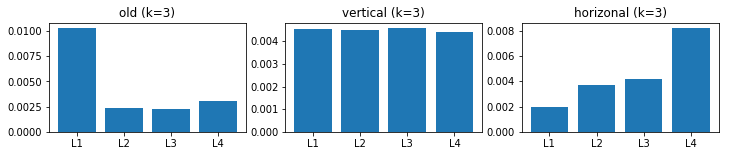

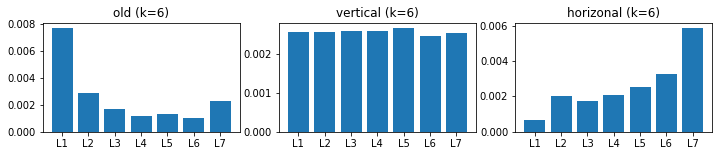

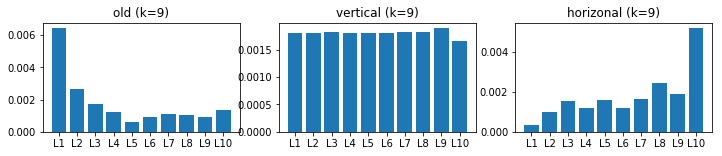

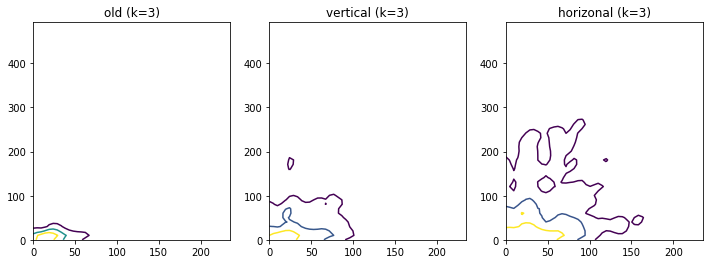

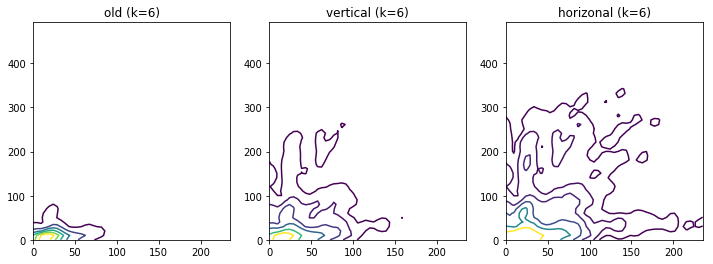

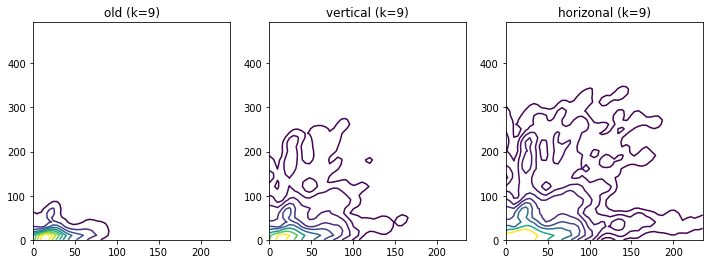

In [111]:
df = pd.read_csv('data/emp_football-data-salary_vs_careergoals.csv', index_col=None, skiprows=1, header=None)
data = df.values.transpose()
mykernel = examples.pdf_kernel(data, kernel_bandwidth=0.15)
indexes = utils.normalize_to_indexes(data=data)
p = examples.support_kde(mykernel, indexes)
plotting.plot_combined(p, indexes[0], indexes[1], k=[3, 6, 9])

### new Idea: area represents equal increase over previous level

Xavi and me came up with another new idea, which I want to try out. It has a different semantic.

The first new idea aims to have the advantage of intuitive intepretation: areas correspond to probability. And this promise is kept, but maybe it is anyway not intuitive in the following sense:

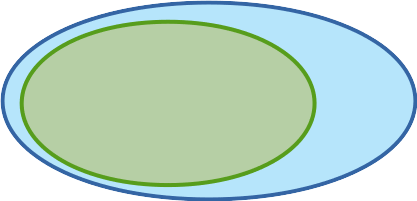

The blue circle is (I believe) interpreted as _containing_ the green one. Now, assigning probabilities to each of the areas, the blue area is _thought_ to be much larger than the green one. However, by construction with our technique both areas encode the same probability and the blue one does _not_ contain the green one. But the blue and green really look like this:

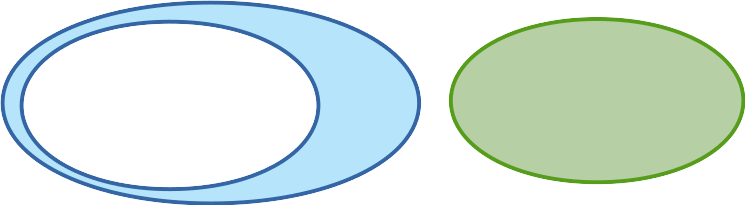

Here, we propose another way of constructing the levels: the levels correspond to actual horizontal cuts of the density funcion and the horizonal slices between all adjacant level should be equal.